In [1]:
import os
from argparse import ArgumentParser
import torch
from matplotlib import pyplot as plt
from typing import Any
import pandas as pd
import re
from tqdm.auto import tqdm

/data/pz/.conda/envs/pzbase/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
module_path = os.path.expanduser('~/sparsity/')
print(module_path)
if module_path not in sys.path: sys.path.append(module_path)
from codes.base.inspect import scan_checkpoints
from codes.modules.hooks import SpectralObservationPlugin


/home/pz/sparsity/


In [20]:
device='cuda:0'
threshold_ratio=10
path = os.path.expanduser('~/sparsity/runs/T5/from_scratch/sparsified/20230919-221826/save')
save_path = os.path.expanduser('~/sparsity/dumps/T5/from_scratch/sparsified/spectral/')
log_threshold_nonzero=-1
log_r_bound=4

In [4]:
def filter(name: str, m: torch.nn.Module):
    if 'mlp.linear.0.weight' not in name and 'mlp.0.weight' not in name and 'DenseReluDense.linear.wi.weight' not in name:
        return False
    print(name)
    return True

def final(weights):
    weight = torch.stack(weights)
    res = SpectralObservationPlugin.spectral_properties(
        torch.ones([1]).to(device),
        weight.to(device),
        threshold_ratio
    )['kkT']

    print(res)

    return res

def reduction(last_result: 'dict[str, dict[str, torch.Tensor]]', name: str, weight):
    if last_result is None: last_result = {}
    res: 'dict[str, torch.Tensor]' = SpectralObservationPlugin.spectral_properties(
        torch.ones([1]).to(device),
        weight.to(device),
        threshold_ratio
    )['kkT']
    # last_result[name] = res
    return {
        **last_result,
        name: res,
    }


models = [
    f'model_{i}.pth' for i in [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 299]
]

checkpoint_dirs = [
    f'checkpoint-{i}' for i in [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 950000, 100000]
]

def checkpoint_filter(name: str):
    basename = os.path.basename(name)
    if basename in models:
        return True
    if 'pytorch' not in name:
        return False
    for d in checkpoint_dirs:
        if d in name:
            return True
    return False

results = scan_checkpoints(
    paths=path,
    filter=filter,
    reduction=reduction,
    map_location=device,
    checkpoint_filter=checkpoint_filter,
)


/home/pz/sparsity/runs/T5/from_scratch/sparsified/20230919-221826/save/checkpoint-20000/pytorch_model.bin
main.model.encoder.block.0.layer.1.DenseReluDense.linear.wi.weight
main.model.encoder.block.1.layer.1.DenseReluDense.linear.wi.weight
main.model.encoder.block.2.layer.1.DenseReluDense.linear.wi.weight
main.model.encoder.block.3.layer.1.DenseReluDense.linear.wi.weight
main.model.encoder.block.4.layer.1.DenseReluDense.linear.wi.weight
main.model.encoder.block.5.layer.1.DenseReluDense.linear.wi.weight
main.model.encoder.block.6.layer.1.DenseReluDense.linear.wi.weight
main.model.encoder.block.7.layer.1.DenseReluDense.linear.wi.weight
main.model.encoder.block.8.layer.1.DenseReluDense.linear.wi.weight
main.model.encoder.block.9.layer.1.DenseReluDense.linear.wi.weight
main.model.encoder.block.10.layer.1.DenseReluDense.linear.wi.weight
main.model.encoder.block.11.layer.1.DenseReluDense.linear.wi.weight
main.model.decoder.block.0.layer.2.DenseReluDense.linear.wi.weight
main.model.decoder.bl

In [5]:
results

{'/home/pz/sparsity/runs/T5/from_scratch/sparsified/20230919-221826/save/checkpoint-20000/pytorch_model.bin': {'main.model.encoder.block.0.layer.1.DenseReluDense.linear.wi.weight': {'average_eigenvalues': (tensor(471.8541, device='cuda:0'),
    tensor([471.8529], device='cuda:0')),
   'zero_rate': tensor(0.9932, device='cuda:0'),
   'max_pseudo_zeros': tensor(4569.8828, device='cuda:0'),
   'average_nonzero_eigenvalues': tensor(55245.4219, device='cuda:0'),
   'ratio': tensor(79.8744, device='cuda:0'),
   'max_eigenvalue': tensor(398073.3438, device='cuda:0'),
   'min_nonzero_eigenvalue': tensor(4983.7407, device='cuda:0'),
   'normal_histogram': {'probabilities': tensor([0.3983, 0.0631, 0.0000, 0.0000, 0.0000, 0.1010, 0.3149, 0.1010, 0.0168,
            0.0035, 0.0014]),
    'bin_edges': tensor([1.0000e-03, 6.4906e-03, 4.2128e-02, 2.7343e-01, 1.7747e+00, 1.1519e+01,
            7.4766e+01, 4.8528e+02, 3.1497e+03, 2.0444e+04, 1.3269e+05, 3.9807e+05])},
   'near_zero_histogram': {'proba

In [7]:
try:
    results_kkT = {int(p[p.find('model_') + len('model_'):-len('.pth')]): value for p, value in results.items()}
except ValueError:
    results_kkT = {int(p[p.find('checkpoint-') + len('checkpoint-'):p.find('/pytorch_model')]): value for p, value in results.items()}


def permute(name):
    def get_depth(module_name):
        ints = re.findall(r'\d+', module_name)
        return int(ints[0]) + int('decoder' in module_name) * 12
        
    dict_module_epoch_value = {}
    for p, checkpoint in results_kkT.items():
        for module, value in checkpoint.items():
            depth = get_depth(module)
            if depth not in dict_module_epoch_value:
                dict_module_epoch_value[depth] = {}
            dict_module_epoch_value[depth][p] = value[name]
    return dict_module_epoch_value
results_kkT = {
    name: permute(name) for name in next(iter(next(iter(results_kkT.values())).values()))
}

In [8]:
def permute_epoch_first(dictionary):
    dict_epoch_module_value = {}
    for depth, module in dictionary.items():
        for epoch, value in module.items():
            if epoch not in dict_epoch_module_value:
                dict_epoch_module_value[epoch] = {}
            dict_epoch_module_value[epoch][depth] = value
    return dict_epoch_module_value
eigenvalues = permute_epoch_first(results_kkT['eigenvalues'])
epochs = list(eigenvalues.keys())
epochs, eigenvalues

([20000, 80000, 40000, 70000, 50000, 90000, 30000, 60000, 10000],
 {20000: {0: tensor([398073.3438, 320695.0312, 123210.6641,  ...,      0.0000,
                0.0000,      0.0000], device='cuda:0'),
   1: tensor([1.8649e+04, 1.2345e+04, 7.4250e+03,  ..., 0.0000e+00, 1.3846e-07,
           0.0000e+00], device='cuda:0'),
   2: tensor([2.0624e+04, 1.6800e+04, 9.9556e+03,  ..., 0.0000e+00, 0.0000e+00,
           6.7685e-08], device='cuda:0'),
   3: tensor([2.7508e+04, 1.7240e+04, 1.1859e+04,  ..., 8.5995e-08, 0.0000e+00,
           3.8257e-08], device='cuda:0'),
   4: tensor([2.0597e+04, 1.4598e+04, 1.0456e+04,  ..., 1.1604e-08, 1.1604e-08,
           0.0000e+00], device='cuda:0'),
   5: tensor([3.4896e+04, 2.0075e+04, 1.2588e+04,  ..., 0.0000e+00, 0.0000e+00,
           1.4763e-07], device='cuda:0'),
   6: tensor([3.9928e+04, 2.3389e+04, 1.6014e+04,  ..., 5.8093e-08, 5.8093e-08,
           0.0000e+00], device='cuda:0'),
   7: tensor([5.0275e+04, 2.4009e+04, 1.6458e+04,  ..., 0.0000e+00,

In [5]:
eigenvalues

tensor([[[1.8106e+01, 3.6117e+00, 2.4346e+00,  ..., 1.0742e-35,
          3.0038e-36, 0.0000e+00],
         [6.6775e+01, 1.5508e+00, 1.3820e+00,  ..., 7.1064e-16,
          7.1064e-16, 0.0000e+00],
         [1.1435e+02, 2.1272e+00, 1.9064e+00,  ..., 3.0134e-14,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.3165e+02, 6.4986e+00, 5.7168e+00,  ..., 0.0000e+00,
          0.0000e+00, 4.4907e-16],
         [1.3002e+02, 8.1443e+00, 7.6494e+00,  ..., 0.0000e+00,
          4.5927e-20, 0.0000e+00],
         [2.9874e+01, 1.0207e+00, 9.3432e-01,  ..., 1.4013e-45,
          0.0000e+00, 0.0000e+00]],

        [[4.2934e+02, 1.1144e+02, 7.8669e+01,  ..., 0.0000e+00,
          6.9472e-11, 6.9472e-11],
         [7.5369e+02, 2.8537e+01, 2.6100e+01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [9.9692e+02, 2.9232e+01, 2.2137e+01,  ..., 1.2331e-11,
          1.8511e-12, 2.3201e-12],
         ...,
         [1.3743e+03, 3.1690e+01, 2.3246e+01,  ..., 2.2140e-10,
          0.000

In [9]:
eigenvalues = torch.stack([
    torch.stack([
        value for depth, value in checkpoint.items()       
    ])    for epoch, checkpoint in eigenvalues.items()
])
torch.save(eigenvalues, os.path.join(save_path, 'eigenvalues.pth'))

In [10]:
eigenvalues = torch.load(os.path.join(save_path, 'eigenvalues.pth'))

In [11]:
eigenvalues.shape

torch.Size([9, 24, 3072])

In [12]:
import matplotlib.pyplot as plt

In [13]:
max_eigenvalue = eigenvalues.max()

/tmp/ipykernel_2986573/2289702830.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_2986573/2289702830.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_2986573/2289702830.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_2986573/2289702830.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_2986573/2289702830.py:60: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/ipykernel_2986573/2289702830.py:60: UserWarning: Tight 

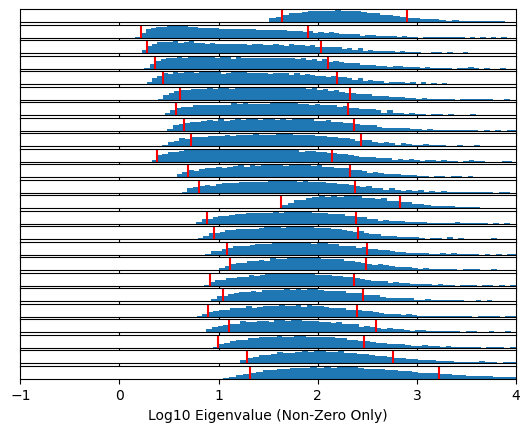

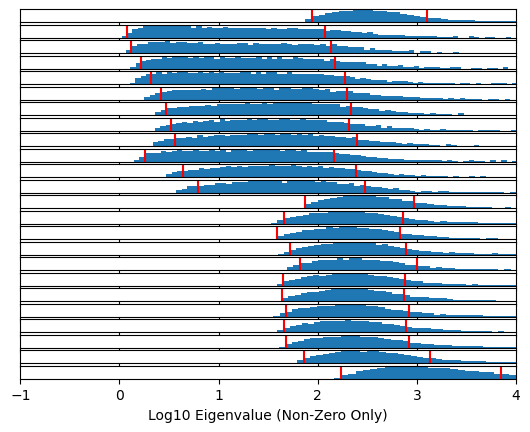

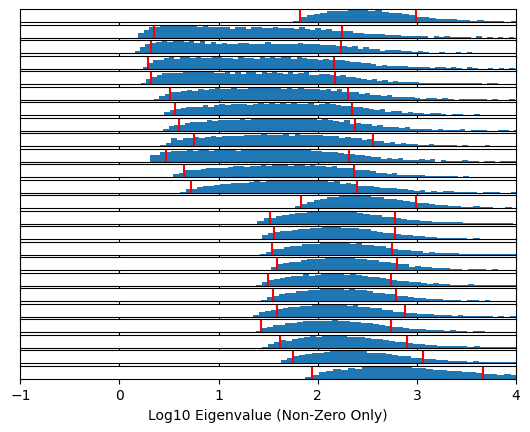

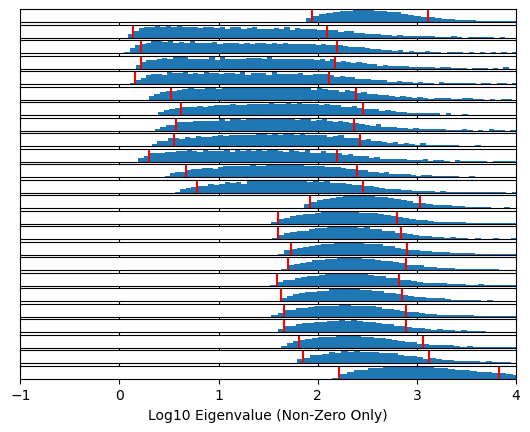

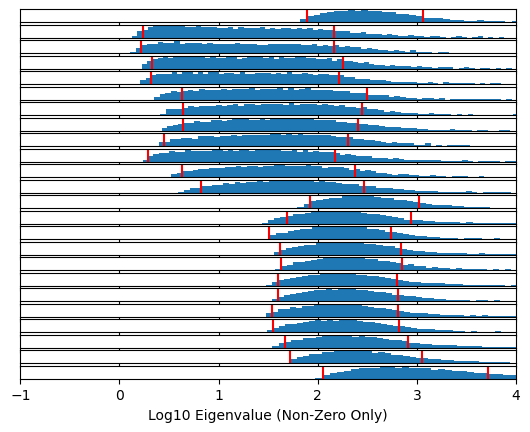

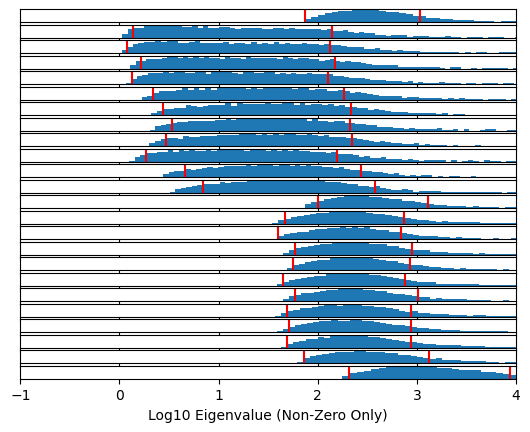

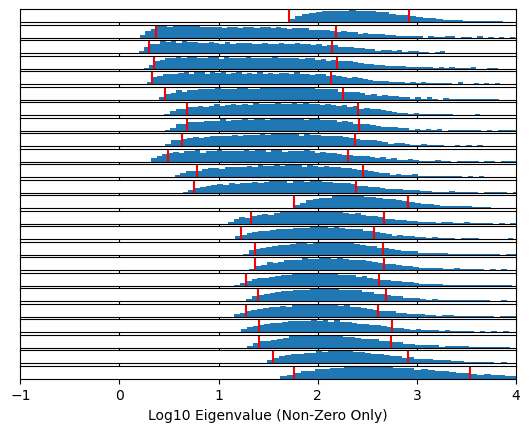

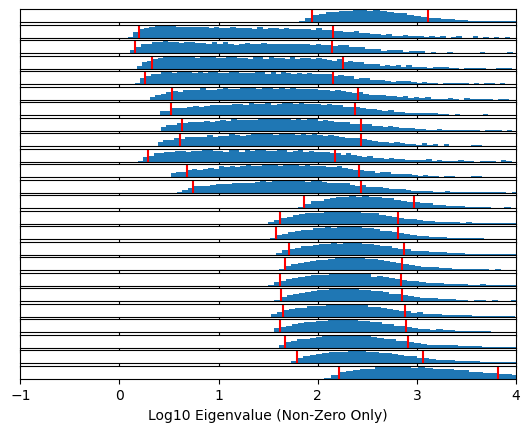

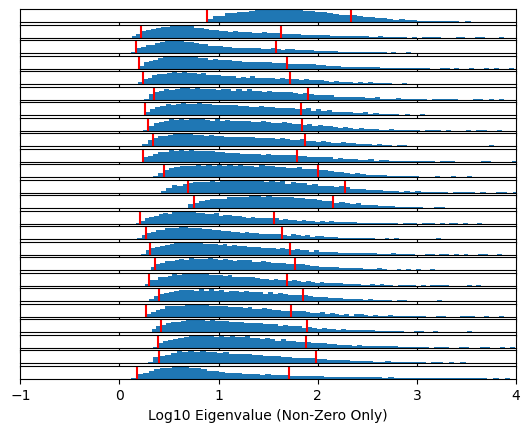

In [22]:
def get_majority(value, bins, threshold=0.8, min_bin_index=0):
    value = value.cpu()
    hist = torch.histogram(value, torch.tensor(bins))
    probabilities = hist[0][min_bin_index:] / hist[0][min_bin_index:].sum()
    bins = bins[min_bin_index:]
    l, r = 0, 0
    sum = 0
    min_interval = None
    while r < len(probabilities):
        if sum < threshold and r + 1 >= len(probabilities):
            break
        while r < len(probabilities) and not (sum >= threshold):
            sum += probabilities[r]
            r += 1
        while l + 1 < r and sum - probabilities[l] >= threshold:
            sum -= probabilities[l]
            l += 1
        if sum >= threshold and (min_interval is None or bins[min_interval[1]] - bins[min_interval[0]] > bins[r] - bins[l]):
            min_interval = (int(l), int(r))
        sum -= probabilities[l]
        l += 1
    return bins[min_interval[0]], bins[min_interval[1]]

def get_log_and_bins(eigval, n_bins_norms=100, near_zero=False):
    log_eigval = eigval.log10()
    l, r = log_threshold_nonzero, float(log_eigval.max())
    bins_norms = [
        i* (r - l) / n_bins_norms + l for i in range(n_bins_norms + 1)
    ]
    bins_small = [-15, -12, -9, -6] if near_zero else []
    bins = bins_small + bins_norms
    return log_eigval, bins, get_majority(log_eigval, bins, min_bin_index=len(bins_small))

checkpoint = eigenvalues[0]

def checkpoint_histogram(checkpoint, save_path=None):
    fig, axs = plt.subplots(len(checkpoint), 1, sharex=True)
    near_zero_rate = []
    majority_width = []
    for i, (ax, eigval) in enumerate(zip(axs, checkpoint.cpu())):
        if i == len(axs) - 1:
            ax.set_xlabel('Log10 Eigenvalue (Non-Zero Only)')
        ax.set_xlim([log_threshold_nonzero, log_r_bound])
        ax.set_yticks([])
        try:
            log_eigval, bins, majority = get_log_and_bins(eigval, near_zero=False)
            ax.hist(log_eigval, bins=bins, label=f'Layer {i+1} (Non-Zero Only)')
            # if i in [0, len(checkpoint) - 1]:
                # ax.set_title(f'Layer {i+1}')
    
            ax.axvline(majority[0], color='red')
            ax.axvline(majority[1], color='red')
            near_zero_rate.append((log_eigval <= log_threshold_nonzero).float().mean())
            majority_width.append(majority[1] - majority[0])
        except:
            near_zero_rate.append(torch.nan)
            majority_width.append(torch.nan)
            continue
        
    plt.tight_layout()
    if save_path is None:
        fig.show()
    else:
        fig.savefig(save_path)
    
    return {
        'near_zero_rate': torch.tensor(near_zero_rate),
        # 'majority_width': torch.tensor(majority_width),
        'ratio': 10**torch.tensor(majority_width)
    }

def visualize_experiment(epochs, eigenvalues, save_path=None) -> 'dict[int, dict[str, torch.Tensor]]':
    statistics = {}
    for epoch, checkpoint in zip(epochs, eigenvalues):
        single_save_path = os.path.join(save_path, f'eigenvalues_{epoch}.jpg') if save_path is not None else None
        single_statistics = checkpoint_histogram(checkpoint, save_path=single_save_path)
        statistics[epoch] = single_statistics
    return statistics

statistics = visualize_experiment(epochs, eigenvalues, save_path=save_path)

torch.Size([9, 24])
torch.Size([9, 24])
torch.Size([9, 24])


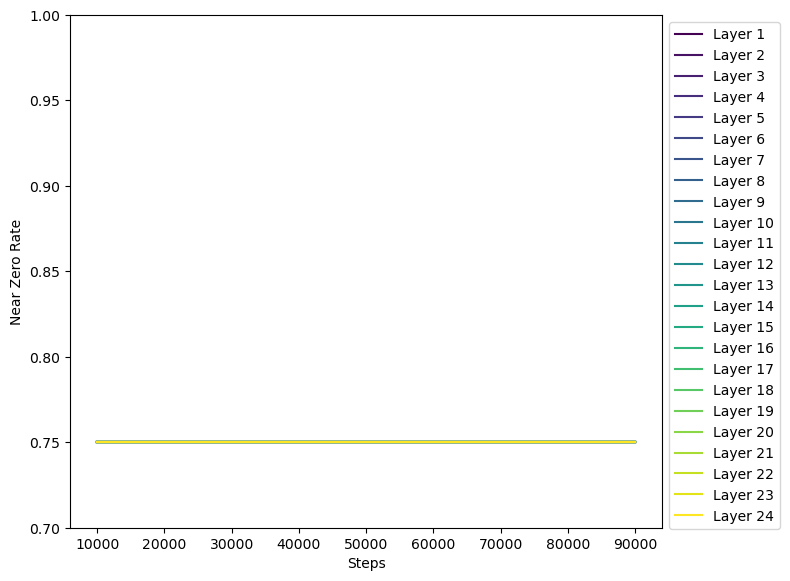

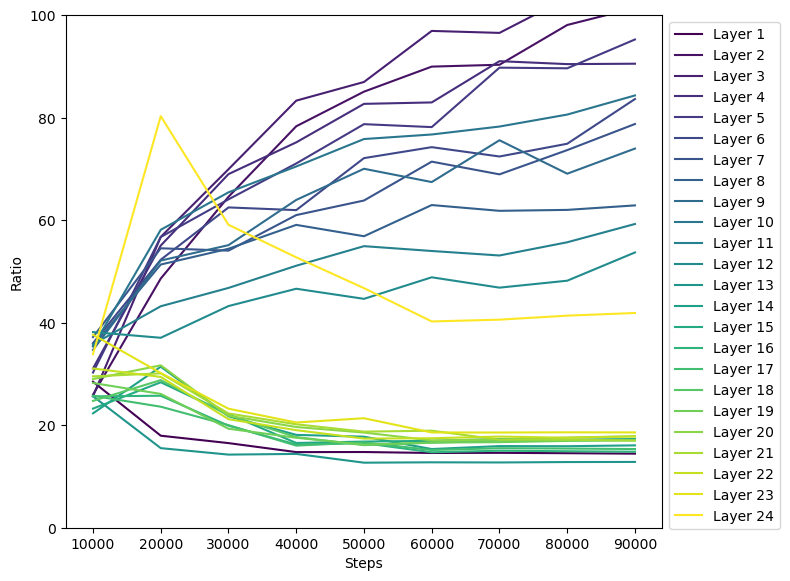

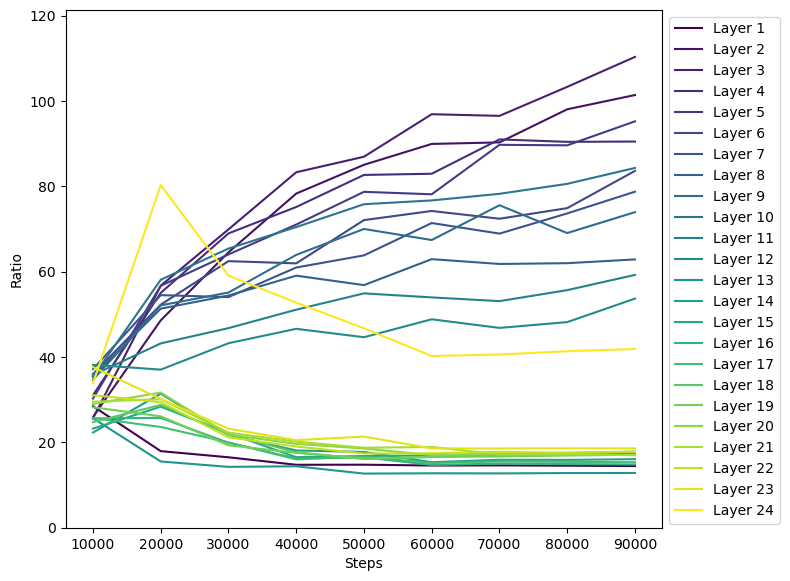

In [24]:
import numpy as np

def plot_lines(data, y_label=None, ylim=None, save_path=None):
    """
    Plot multiple lines based on the provided data structure.

    Args:
    - data (list): List of tuples. Each tuple consists of a label and a list of (x, y) values.
                  e.g. [(label, [(x, y)])]

    Returns:
    - None
    """
    
    # Extract unique labels and assign colors from the Viridis colormap
    labels = [item[0] for item in data]
    colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    if ylim is not None:
        ax.set_ylim(ylim)
    if y_label is not None:
        ax.set_ylabel(y_label)

    for (label, values), color in zip(data, colors):
        x_values = [x[0] for x in values]
        y_values = [x[1] for x in values]
        ax.plot(x_values, y_values, label=f"Layer {label}", color=color)
        ax.set_xlabel("Epochs" if max(x_values) <= 1000 else "Steps") 

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path, bbox_inches='tight')


def visualize_changes(statistics: 'dict[int, dict[str, torch.Tensor]]', save_path=None):
    epochs = list(statistics.keys())
    dict_name_epoch: 'dict[str, dict[int, torch.Tensor]]' = {}
    for epoch, checkpoint in statistics.items():
        for name, value in checkpoint.items():
            if name not in dict_name_epoch:
                dict_name_epoch[name] = {}
            dict_name_epoch[name][epoch] = value
    dict_name_value = {
        name: torch.stack([value for epoch, value in indexed_values.items()]) for name, indexed_values in dict_name_epoch.items()
    }
    dict_name_value = {
        **dict_name_value,
        'ratio_full': dict_name_value['ratio']
    }

    ylims = {
        'ratio': [0, dict_name_value['ratio'].reshape(-1)[~dict_name_value['ratio'].reshape(-1).isnan()].max() * 1.1],
        'ratio_full': [0, dict_name_value['ratio'].reshape(-1)[~dict_name_value['ratio'].reshape(-1).isnan()].max() * 1.1],
        'near_zero_rate': [0.7, 1]
    }
    ylims['ratio'][1] = min(ylims['ratio'][1], 100)

    y_labels = {
        'ratio': 'Ratio',
        'ratio_full': 'Ratio',
        'near_zero_rate': 'Near Zero Rate'
    }

    for name, values in dict_name_value.items():
        print(values.shape)
        lines = [
            (layer_id + 1, sorted([(epochs[epoch_id], float(value)) for epoch_id, value in enumerate(values[:, layer_id])])) 
                for layer_id in range(0, values.shape[-1])
        ]



        plot_lines(
            lines,
            ylim=ylims[name],
            y_label=y_labels[name],
            save_path=os.path.join(save_path, name + '.jpg') if save_path is not None else None
        )

visualize_changes(statistics, save_path=save_path)

